In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_machine_learning.datasets import ad_hoc_data
from itertools import chain, combinations
import random

In [2]:
from qiskit_aer import AerSimulator
sim = AerSimulator()

# Ad Hoc Data

In [3]:
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )

In [4]:
def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

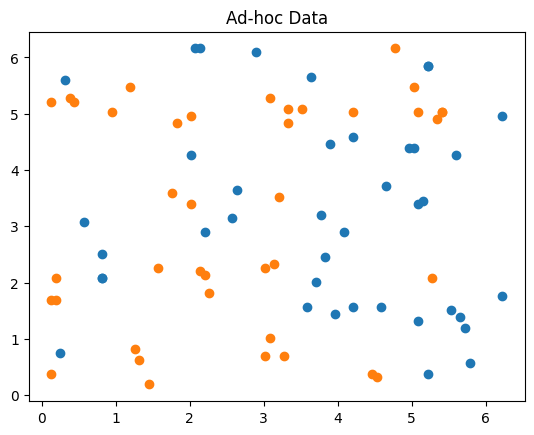

Training labels[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1]
Test labels[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1]
Size of training data(80, 2) (80,)
Size of test data(80, 2) (80,)


In [5]:
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=40,
    test_size=40,
    n=2,
    gap=0.3,
    plot_data=True,
    one_hot=False,
    include_sample_total=True,
)
train_labels = np.where(train_labels == 0, -1, 1)
test_labels = np.where(test_labels == 0, -1, 1)

print("Training labels" + str(train_labels))
print("Test labels" + str(test_labels))
print("Size of training data" + str(train_features.shape) + " " + str(train_labels.shape))
print("Size of test data" + str(test_features.shape) + " " + str(test_labels.shape))


In [6]:
#plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)
# Only works with 2 features

# Feature Map

In [7]:
def powerset(iterable, size):
    s = list(range(len(iterable)))
    return chain.from_iterable(combinations(s, r) for r in range(size + 1))

In [8]:
def feature_map_custom(fm, x, reps):
    list_of_set = list(powerset(x, 2))

    for _ in range(reps):
        for i in range(len(x)):
            fm.h(i)
        for l in list_of_set:
            if len(l) == 0:
                continue
            if len(l) == 1:
                fm.p(-2 * x[l[0]], l[0])
            else:
                (i, j) = l
                fm.cx(i, j)
                fm.p(-2 *(np.pi-x[i])*(np.pi-x[j]), j)
                fm.cx(i, j)
        fm.barrier()
        

In [9]:
def display_featur_map(size, reps):
    fm = QuantumCircuit(size)
    angels = [1.0] * size
    feature_map_custom(fm, angels, reps)
    return fm.decompose("U_phi").draw(output='mpl')

## Feature Maps Displayed

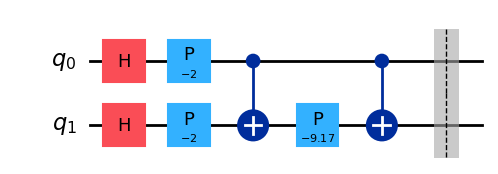

In [10]:
display_featur_map(size = 2, reps = 1)

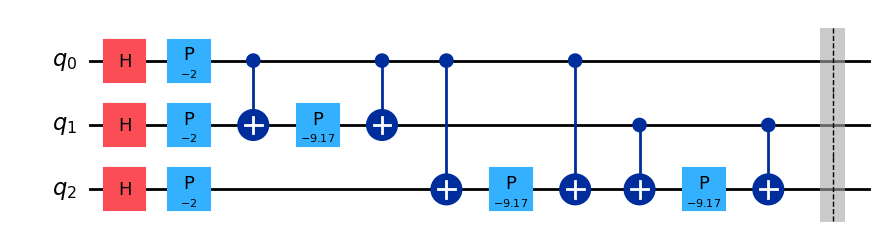

In [11]:
display_featur_map(size= 3, reps=1)

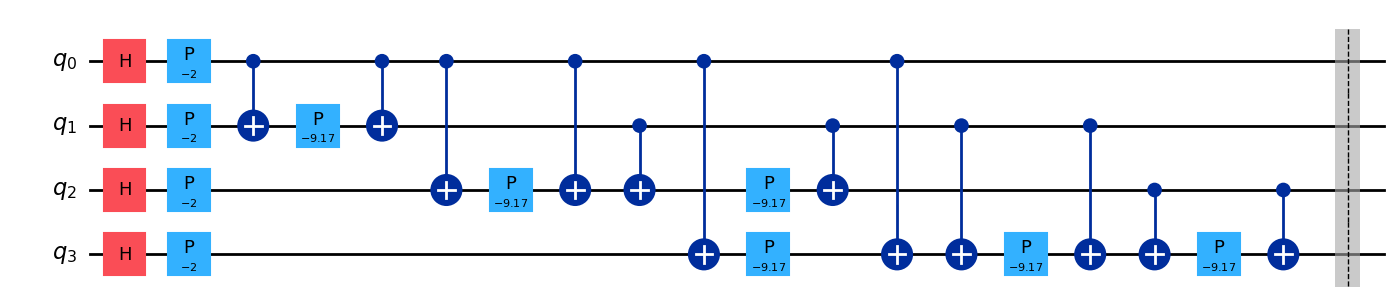

In [12]:
display_featur_map(size= 4, reps=1)

# Ansatz

In [13]:
def ansatz_custom(ansatz, theta, nbr_of_qubits, reps):  
    for i in range(reps+1):
        for j in range(0, nbr_of_qubits*2, 2):
            ansatz.ry(theta[(nbr_of_qubits*2)*i+j], int(j/2))
            ansatz.rz(theta[(nbr_of_qubits*2)*i+j+1], int(j/2))
        if i != reps:
            for j in range(nbr_of_qubits-1):
                for k in range(j+1, nbr_of_qubits):
                    ansatz.cz(j, k)

In [14]:
def display_ansatz(size, reps):
    ansatz = QuantumCircuit(size)
    theta = [1.0] * (2*size * (reps+1))
    print(theta)
    ansatz_custom(ansatz, theta, size, reps)
    return ansatz.draw(output='mpl')

[1.0, 1.0, 1.0, 1.0]


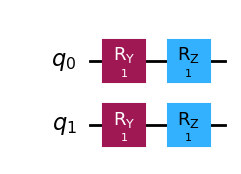

In [15]:
display_ansatz(size=2, reps=0)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


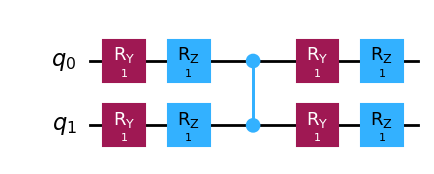

In [16]:
display_ansatz(size=2, reps=1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


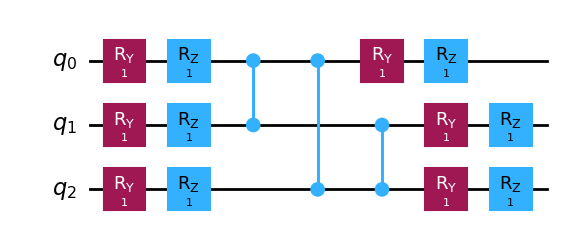

In [17]:
display_ansatz(size=3, reps=1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


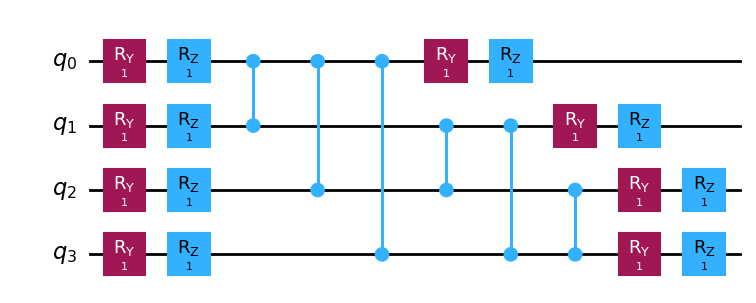

In [18]:
display_ansatz(size=4, reps=1)

# Other Ansatz

In [19]:
def ansatz_custom_other(ansatz, theta, nbr_of_qubits, reps):
    for i in range(reps+1):
        for j in range(0, nbr_of_qubits*2, 2):
            ansatz.ry(theta[(nbr_of_qubits*2)*i+j], int(j/2))
            ansatz.rz(theta[(nbr_of_qubits*2)*i+j+1], int(j/2))
        if i != reps:
            for j in range(nbr_of_qubits-1):
                ansatz.cz(j, j+1)
            if nbr_of_qubits > 2:
                ansatz.cz(0, nbr_of_qubits-1)

In [20]:
def display_ansatz_other(size, reps):
    ansatz = QuantumCircuit(size)
    theta = [1.0] * (2*size * (reps+1))
    ansatz_custom_other(ansatz, theta, size, reps)
    return ansatz.draw(output='mpl')

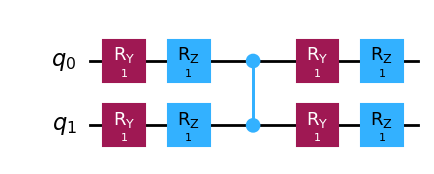

In [21]:
display_ansatz_other(size=2, reps=1)

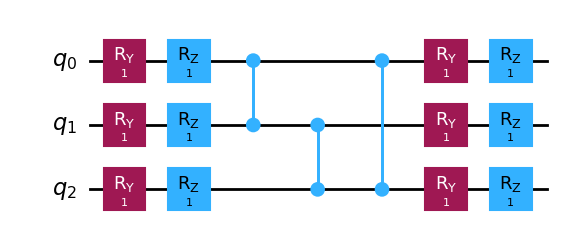

In [22]:
display_ansatz_other(size=3, reps=1)

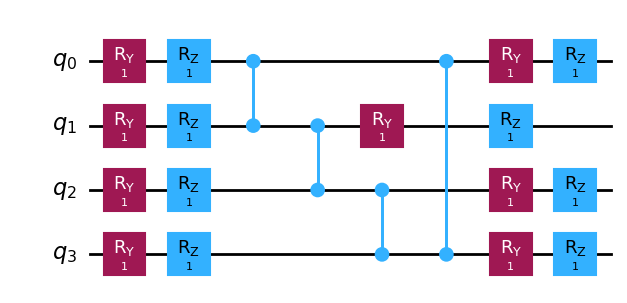

In [23]:
display_ansatz_other(size=4, reps=1)

# Implementation

In [24]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [25]:
def single_circuit_evaluation(x, theta, reps_feature, reps_thetas, shots):
    size = len(x)
    qc = QuantumCircuit(size)
    feature_map_custom(fm = qc, x = x, reps = reps_feature)
    ansatz_custom(ansatz = qc, theta = theta, nbr_of_qubits = size, reps = reps_thetas)
    qc.measure_all()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

In [26]:
def compute_empirical_risk(train_features, train_labels, w, reps_feature, reps_thetas, shots):
    r = shots/10
    y = 0
    theta = w[:-1]
    b = w[-1]

    empirical_risk = 0
    for i in range(len(train_labels)):
        py_empirical = 0
        counts = single_circuit_evaluation(train_features[i], theta, reps_feature, reps_thetas, shots)
        
        p_0 = (counts.get("00", 0)+counts.get("11", 0))/shots
        p_1 = (counts.get("01", 0)+counts.get("10", 0))/shots
        if train_labels[i] == 1:
            py_empirical = p_1
            y = 1
        else:
            py_empirical = p_0
            y = -1
        top = np.sqrt(r)*(0.5-(py_empirical-0.5*(y*b)))
        bottom = np.sqrt(2*(1-py_empirical)*py_empirical)
        empirical_risk += sigmoid(top/bottom)   
    empirical_risk /= len(train_labels)
    return empirical_risk


In [27]:
def compute_grad(train_features, train_labels, w, ck, reps_feature, reps_thetas, shots):
    deltak = np.random.choice([-1, 1], len(w))

    lossplus = compute_empirical_risk(train_features, train_labels, w+ck*deltak, reps_feature, reps_thetas, shots)
    lossminus = compute_empirical_risk(train_features, train_labels, w-ck*deltak, reps_feature, reps_thetas, shots)

    avg_loss = (lossplus+lossminus)/2
    grad = (lossplus-lossminus)/(2*ck*(deltak))
    
    return grad, avg_loss

In [28]:
def init_c(train_features, train_labels, w, reps_feature, reps_thetas, shots):
    steps = 10
    coefficent = 100

    empirical_list = []
    for _ in range(steps):
        empirical_list.append(compute_empirical_risk(train_features, train_labels, w, reps_feature, reps_thetas, shots))
    loss_list = np.abs(np.diff(empirical_list))
    return np.std(loss_list)*coefficent

In [29]:
def init_a(train_features, train_labels, w, c, A, alpha, reps_feature, reps_thetas, shots):
    target_magnitudes = 0.15

    grad, _ = compute_grad(train_features, train_labels, w, c, reps_feature, reps_thetas, shots)
    avg_magnitudes = np.abs(grad)
        
    return (target_magnitudes*(A**alpha) / avg_magnitudes.mean())

In [30]:
def do_spsa(train_features, train_labels, w, reps_feature, reps_thetas, shots, N=100, alpha = 0.602, gamma = 0.101,):
    A = N * 0.01
    c = init_c(train_features, train_labels, w, reps_feature, reps_thetas, shots)
    a = init_a(train_features, train_labels, w, c, A, alpha, reps_feature, reps_thetas, shots)
    print("a: ", a)
    print("c: ", c)

    loss_list = []

    min_w = w
    min_loss = 1

    for k in range(1, N):
        ak = a / (A + k)**alpha
        ck = c / (k**gamma)
        gk, loss  = compute_grad(train_features, train_labels, w, ck, reps_feature, reps_thetas, shots)

        loss_list.append(loss)
        
        if loss < min_loss:
            min_loss = loss
            min_w = w

        print("\nIteration: ", k)
        print("Loss: ", loss)
        print("Grad norm: ", np.linalg.norm(gk))

        if loss < 0.11:
            break

        w = w - ak*gk

    return min_w, loss_list

In [31]:
def training_phase(train_features, train_labels, reps_feature, reps_thetas, shots=2000):
    theta = [1.0] * (2*len(train_features[0]) * (reps_thetas+1))
    b = 0
    
    w = theta + [b]
    theta, loss_list = do_spsa(train_features, train_labels, w, reps_feature, reps_thetas, shots=shots)
    return theta, loss_list

In [32]:
def classification_phase(test_features, test_labels, theta_optimal, reps_feature, reps_thetas, shots=10000):
    predictions = []
    for i in range(len(test_features)):
        counts = single_circuit_evaluation(test_features[i], theta_optimal, reps_feature, reps_thetas, shots)
        p_0 = (counts.get("00", 0)+counts.get("11", 0))/shots
        p_1 = (counts.get("01", 0)+counts.get("10", 0))/shots
        if p_0 > p_1:
            predictions.append(-1)
        else:
            predictions.append(1)
    
    
    print("Test labels")
    print(test_labels)
    print("Predicted labels")
    print(predictions)
    success_rate = np.sum(np.equal(predictions, test_labels))/len(test_labels)
    print("Success rate: ", success_rate)
    return predictions, success_rate

In [33]:
#theta_optimal, _ = training_phase(train_features, train_labels, reps_feature=2, reps_thetas=1)

In [34]:
#predict_labels, success_rate = classification_phase(train_features, train_labels, theta_optimal, reps_feature=2, reps_thetas=1)

In [35]:
#predict_labels, success_rate = classification_phase(test_features, test_labels, theta_optimal, reps_feature=2, reps_thetas=1)

In [36]:
def run_plot():
    train_features, train_labels, test_features, test_labels = ad_hoc_data(
        training_size=40, test_size=800, n=2, gap=0.3, one_hot=False, include_sample_total=True
    )
    train_labels = np.where(train_labels == 0, -1, 1)
    test_labels = np.where(test_labels == 0, -1, 1)

    success_rates = []

    for reps_thetas in range(5):
        theta_optimal, loss_list = training_phase(train_features, train_labels, 2, reps_thetas)

        for i in range(20):
            used_test_features = test_features[i*40:(i+1)*40]
            used_test_labels = test_labels[i*40:(i+1)*40]
            predict_labels, success_rate = classification_phase(used_test_features, used_test_labels, theta_optimal, 2, reps_thetas)
            success_rates.append(success_rate)

    return success_rates